# Pocking at Ever Larger Language Models
### An introduction for (digital) humanists

## Part 1: Exploring N-gram language models

In this notebook:
- We explain some of the basic terminology and principles of language models
- Build a simple language model that generates endless (and senseless!) Brexit discourse. Yay!

In creating this notebook, I leaned heavily on:
- the excellent Programming Historian lesson on [Generating Text with GPT-2](https://programminghistorian.org/assets/interrogating-national-narrative-gpt/)
- The [Chapter](https://web.stanford.edu/~jurafsky/slp3/3.pdf) on N-Gram Language Models in the fabulous handbook by Dan Jurafsky and James H. Martin "Speech and Language Processing" (3rd ed. draft). Available online [here](https://web.stanford.edu/~jurafsky/slp3/).


# What are N-Grams?

N-grams are sequences of *n* words.

The sentence “predicting the future is impossible”
- Unigrams: `predicting`,`the `, `future`, `is`, `impossible`
- Bigrams:  `predicting the`,`the future`, `future is`, `is impossible`
- Trigrams: `predicting the future`, `the future is`, `future is impossible`


# What are language models
## What is likely to come next?

> “[Language models] assign a probability* to each possible next word. (Jurafsky & Martin)”

In other words, language models guess what word comes next.

Given the sentence **“Predicting the future is hard, but not …”**

- P(“impossible” | sentence) is greater than P(“aardvark” | sentence)


```Read P(“impossible” | sentence) as the probability of observing the token “impossible” given the sequence “Predicting the future is hard, but not ..."```


```Probabilities are values between 0 and 1 that sum up to 1.```

**Peaking ahead**: if you can predict what comes next in a text sequence you learn quite a lot about language user and the world in general.

- Paris is located in [BLANK]
- He was late. I was really angry and told [BLANK]

## How probable is a text?

> “[Language models] assign a probability to an entire sequence. (Jurafsky & Martin)”

**P(predicting the future is hard, but not impossible)**

Is greater than

**P(predicting the future is hard, but not aardvark)**


### How to compute probability of a text?

**P(predicting the future is impossible)**

Is equal to:

`P(predicting)` * `P(the | predicting)` * `P(future | predicting the)` * `P(is | predicting the future)` * `P(impossible | predicting the future is)` etc.

# N-Gram Language Models

How to compute ```P(impossible | predicting the future is)```? with a **trigram** language model (n=3).

- When predicting the next word we only take into account the past two words (Markov Assumption for trigram language model)
    i.e. instead of ``P(impossible | predicting the future is)`` we use ``P(impossible | future is)``
   
- Wow, this is crazy! Imagine you have to make a speech, but you can only remember the last two words.
![forgot](https://media.giphy.com/media/dSdvJvsJQIXWsgP6cO/giphy.gif)

Ok, let's assume the Markov assumption makes sense. How to compute ```P(impossible | future is)```

You need 
- [x] lots of data
- [x] an N-gram counter
- [x] a calculator

> The language modelling task: **P(w | h)** (predict the probability of word w given a history h)

We can estimate the probability from counts:

- P(impossible | predicting the future is) ≈ P(impossible | future is) (Markov assumption)
- P(impossible | future is) = C(future is impossible) / C(future is) (Likelihood estimation)

Important
- By computing the probabilities we **train** the N-gram language model on the actual text.
- When we repeat this computation for **every word** in our vocabulary, then get a probability distribution over the next word, i.e.

P(impossible | future is) = .05

P(not | future is) = .07
...

P(flower | future is) = .00001


**Please notice**: Having a higher order language model (i.e. n > 3) will generally create a better model, but it makes the computation more complex. Language is highly variable, and many sequences will never be observed (i.e. the denominator equals zero). Also, you need to keep track of more counts!

There are various solutions to this, which we will not discuss here (but you can have a look at this [Chapter](https://web.stanford.edu/~jurafsky/slp3/3.pdf)).

## Quick recap
- Language modelling is the task of predicting the next word *w* given a history *h* (i.e. P(w | h))
- At each step, we can compute the probability over all the following words
- We can measure the **performance** of a model by evaluating how well a model can predict the next word (it will assign higher probabilities to actual texts)

# Practical: Generating Brexit Prose with a Bigram Language Model

In the sections below, we build a simple n-gram model to generate text.

- Given an input (or prompt), a language model will output a probability over the next words
- We will sample from this distribution to select the next word and repeat the process (ad infinitum if you like;-))

Even though the machinery has become way more complicated, these components are still the main building blocks behind generative technologies such as ChatGPT.

## Install Packages

We work in Colab Notebooks, and before we start playing with code we need to install some packages.

Below you see a code cell. 

**Action**: Remove the # at the start of each line and run the cell.

In [478]:
#!wget -O requirements.txt https://raw.githubusercontent.com/kasparvonbeelen/SAS-LLM-Worshop/main/requirements.txt
#!pip install -r requirements.txt

### Install packages

In [ ]:
%%bash
pip install requests

### Import packages

In [479]:
import numpy as np
import requests
from collections import Counter
import re
import pandas as pd

### Download data

We download the texts from the Programming Historian and save them in a variable with the name 'text'.

The inspect its content, we can print the first 100 characters. If you are new to Python, congratulations, you have just run your first small program! Congratulations.

In [480]:
# download data and save the information in the text variable
text = requests.get('https://programminghistorian.org/assets/interrogating-national-narrative-gpt/articles.txt').text
# print the first hundred characters
print(text[:100])

UK opposition parties have agreed not to back Boris Johnson's demand for a general election before t


### Processing the documents

Each line in this document contains a sentence related to Brexit. 

To use these texts as input to our language, we need to process them. We want to simplify the input so it's easier to construct a language model.
-  lowercase the texts
- add a start `<s>` and end `</s>` symbol to each sentence
- remove punctuation

**Please note**: These steps are not necessarily recommended (they remove valuable information when you want to model a sequence). But for this tutorial, we want to keep things simple and therefore have to cut corners here and there.

In [481]:
# add start and end symbol to a sentence
format_sentence = lambda s: ['<s>'] + pattern.findall(s) + ['</s>']

def process_texts(text: str) -> list:
    """
    A functions that process a text input. This function assumens that lines
    correspond with sentences. This function will wrap the sentences with 
    start and end tags (<s> and </s>) and split the sentence into tokens.
    At the ends all sentences are combined into one list of tokens.
    
    Arguments
        text (str): a text document with a sentences on each line (seperated by \n) 
    Returns
         tokens (list): return the input text as one long sequence of tokens
    """
    pattern = re.compile('\w+')

    text = text.lower()
    sentences = [format_sentence(s) for s in text.split('\n')]
    return [w for s in sentences for w in s]

The `process_texts` function will prepare our data for training the language model. You can read the docstring to better understand what the function requires as input, how it process this input and what it returns.

In [482]:
tokens = process_texts(text) # apply process texts to our document
print('The total number of tokens in our corpus is: ',len(tokens))
print('The first 20 tokens are: ',tokens[:20])

The total number of tokens in our corpus is:  4342340
The first 20 tokens are:  ['<s>', 'uk', 'opposition', 'parties', 'have', 'agreed', 'not', 'to', 'back', 'boris', 'johnson', 's', 'demand', 'for', 'a', 'general', 'election', 'before', 'the', 'eu']


### Obtain the vocubulary

In [454]:
vocabulary = set(tokens) # get the vocabulary, all the unique tokens in our corpus
print(f'The vocabulary contains {len(vocabulary)} distinct words.')

The vocabulary contains 39924 distinct words.


After processing the input data, we can start building our language model using n-gram counts. As explained in the introduction, need to compute the P(w | h), probabily of observing word w given history h.  We approximate this with bigram language model, which uses the relative counts for calculating the likelihood of observing w after h. 

Below we created a function that returns n-grams of length n given a sequence (of tokens).

### Compute N-Gram counts

In [456]:
def ngrams(tokens: list,n: int=2):
    """
    A function the returns ngrams with length n as a list
    
    Arguments:
        tokens (list): a list of tokens processed 
        with the process_texts function
        n (int): an integer that determines the length of the n-grams
    Returns:
        a list in which each elements is n-gram of tokens represented as a string
    """
    return [' '.join(tokens[i:i+n]) for i in range(len(tokens))]



We can start with the simplest example of bigrams, sequences of length two.

In [457]:
bigrams_list = ngrams(tokens,2) # compute bigrams
bigrams_list[:10] # print first 10 bigrams

['<s> uk',
 'uk opposition',
 'opposition parties',
 'parties have',
 'have agreed',
 'agreed not',
 'not to',
 'to back',
 'back boris',
 'boris johnson']

As we need the n-grams counts for computing the likelihood, we need feed this list of bigrams to a `Counter` object.

In [458]:
bigrams = Counter(bigrams_list) # compute bigram counts
print(bigrams.most_common(5)) # print 5 most common bigrams

[('</s> <s>', 130568), ('of the', 25933), ('the eu', 20235), ('in the', 20000), ('<s> the', 17367)]


In [459]:
trigrams = Counter(ngrams(tokens,3)) # create n-grams of length 3
quadgrams = Counter(ngrams(tokens,4)) # create n-grams of length 4

In [460]:
#print([w for w,v in trigrams.most_common()][:10])

In [461]:
#print([w for w,v in trigrams.most_common() if w.startswith('<s>')][:10])

### Compute the probabilities over the next word

Let's now compute, step by step, the next word for an input sequence. We use the trigram "a no deal" as prompt, and calculate what tokens is likely to follow.

How likely is 'brexit' to follow 'a no deal'?

In [471]:
sequence = 'a no deal' # prompt or history
w = 'brexit' # next word w
probability = quadgram[f'{sequence} {w}'] / trigrams[sequence] # compute P(h | w)
print(f'The probability of "{w}" following "{sequence}" is {probability:.3f}') # print result of computation

The probability of "brexit" following "a no deal" is 0.646


However, we need to calculate these probabilities for each word in our vocabulary. Luckily we have machines to do that.

In [472]:
# compute P(w | h) for each word w in our vocabulary
prob_next_word = Counter({w: quadgram[f'{sequence} {w}'] / trigrams[sequence] for w in vocabulary}) 

In [473]:
# print ten most probably words that can follow the input
prob_next_word.most_common(10)

[('brexit', 0.64616782793093),
 ('exit', 0.07906694940926992),
 ('scenario', 0.06846410178733717),
 ('outcome', 0.028476219327476522),
 ('</s>', 0.025446834292638595),
 ('departure', 0.016964556195092396),
 ('and', 0.006664647076643442),
 ('situation', 0.005755831566192063),
 ('would', 0.005755831566192063),
 ('or', 0.00545289306270827)]

We can visualize the distribution of these probabilities using a bar chart. We only focus on the twenty words with the highest scores.

<Axes: title={'center': 'probability of next word'}>

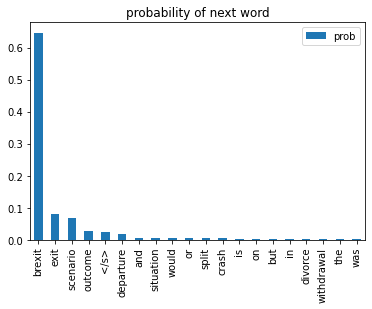

In [466]:
df_prob = pd.DataFrame(list(prob_next_word.most_common(20)),columns=['token','prob'])
df_prob.index = list(df_prob["token"])
df_prob.plot(kind='bar', title='probability of next word')

### Sample from the probabilities

After computing the probabilities, we sample the next word. This adds a stochastic element to language models, i.e. outputs may differ each time. 


In [475]:
words, probs = list(prob_next_word),list(prob_next_word.values())

In [476]:
np.random.choice(words, p=probs)

'brexit'

While words with a high probability are more likely to be selected, the outcome differs on each trial.

In [477]:
for _ in range(10):
    print(np.random.choice(words, p=probs))

brexit
outcome
exit
</s>
scenario
brexit
withdrawal
brexit
exit
brexit


### Generate text from a prompt

In [474]:
def generate_text(sequence: str) -> str:
    """
    Given an input or prompt, keep on generating text until 
    you encounter the end-of-sentence token.
    
    Arguments:
        sequence (str): input sequence or prompt
    
    Returns:
        a generated text sequence 
    """
    
    total_sequence = sequence # to keep track of each prediction we create a variable with the name total_sequence

    next_word = None # we need to define the next word, but assign it a None value

    while next_word != '</s>': # we keep generating text untill we encounter the end of sentence token
        prob_next_word = Counter({w: quadgram[f'{sequence} {w}'] / trigrams[sequence] for w in vocabulary}) # compute probabilities
        words, probs = list(prob_next_word),list(prob_next_word.values()) # compute probabilities
        next_word = np.random.choice(words, p=probs) # sample
        total_sequence += ' ' + next_word # add sampled word to sequence
        sequence = ' '.join(total_sequence.split()[-3:]) # change the history to include to last three words
    return total_sequence # return sequence after encountering a stop symbol


In [470]:
start_sequence = '<s> theresa may' # select a sequnence as a prompt to start generating texts
#start_sequence = '<s> boris johnson'
generate_text(start_sequence)

'<s> theresa may entered office three years ago mrs may pledges to fight burning injustices in society here she lists her proudest achievements mental health funding domestic abuse an audit of racial discrimination and gender pay gap and organic food he was also a remainer in his heart the shadow chancellor wants to postpone as many serious decisions as possible until next year the uk should strike with the eu27 and the uk ended up contesting european elections </s>'

# Fin.